In [ ]:
!unzip R43.zip
!ls -l R43.txt
!pip install scikit-dimension
!pip install pyod            
!pip install --upgrade pyod  
!pip install suod

Archive:  R43.zip
  inflating: R43.txt                 
-rw-r--r-- 1 root root 51210834 Aug  1 11:38 R43.txt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
with open("R43.txt", "r") as f:
  d, n, m, k, p = [-1 if x == "_" else int(x) for x in f.readline().split()]
  ks = [int(x) for x in f.readline().split()]
  data = [[float(x) for x in string.split()] for string in f.readlines()]
  data = np.array(data)

data.shape

(83732, 100)

In [ ]:
def get_pca_outlier_score():
  from pyod.models.pca import PCA as Outlier_PCA
  clf = Outlier_PCA(n_selected_components=3)
  clf.fit(data)
  return (clf.decision_scores_ - np.min(clf.decision_scores_)) / (np.max(clf.decision_scores_) - np.min(clf.decision_scores_))

def get_gmm_outlier_score():
  from pyod.models.gmm import GMM as Outlier_GMM
  clf = Outlier_GMM()
  clf.fit(data)
  return (clf.decision_scores_ - np.min(clf.decision_scores_)) / (np.max(clf.decision_scores_) - np.min(clf.decision_scores_))

def get_lof_outlier_score():
  from pyod.models.lof import LOF as Outlier_LOF
  clf = Outlier_LOF()
  clf.fit(data)
  return (clf.decision_scores_ - np.min(clf.decision_scores_)) / (np.max(clf.decision_scores_) - np.min(clf.decision_scores_))

def outlier_detection():
  scores = get_pca_outlier_score() + get_gmm_outlier_score() + get_lof_outlier_score()
  idx = np.argpartition(scores, -p)
  outliers = idx[-p:]
  normals = idx[:-p]
  return outliers, normals

outliers, normals = outlier_detection()



In [ ]:
k

49

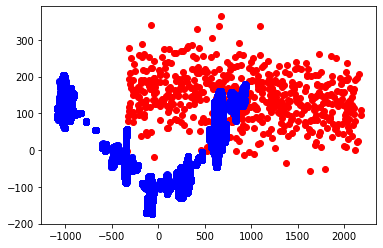

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(data)
plt.scatter(pca_embedded[outliers][:,0], pca_embedded[outliers][:,1], c = 'red')
plt.scatter(pca_embedded[normals][:,0], pca_embedded[normals][:,1], c = 'blue')
plt.show()

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np

clustering_new = MiniBatchKMeans(n_clusters=10000, random_state=42).fit(data[normals])
mini_dataset = clustering_new.cluster_centers_

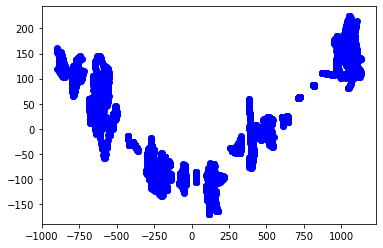

In [ ]:
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(mini_dataset)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = 'blue')
plt.show()

In [ ]:
from scipy.spatial.distance import euclidean, pdist, squareform
def similarity_func(u, v):
    return 1/(1+euclidean(u,v))
dists = pdist(mini_dataset, similarity_func)
similarity_matrix = squareform(dists)

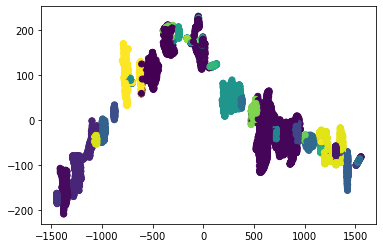

In [ ]:
from sklearn.cluster import SpectralClustering
clustering_minidataset = SpectralClustering(n_clusters=k, affinity = 'precomputed', random_state=42).fit(similarity_matrix)

pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(mini_dataset)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = clustering_minidataset.labels_)
plt.show()

In [ ]:
!pip install umap-learn
import umap
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0.0,
    n_components=d,
    random_state=42,
).fit_transform(mini_dataset)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


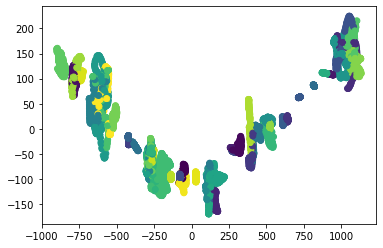

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
clustering_minidataset = SpectralClustering(n_clusters=k, n_neighbors=50).fit(clusterable_embedding)
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(mini_dataset)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = clustering_minidataset.labels_)
plt.show()

In [ ]:
m = k

In [ ]:
labels = []
for j in range(k):
  current_label = np.array([])
  for i in list(np.arange(10000)[clustering_minidataset.labels_ == j]):
    current_label = np.union1d(current_label, normals[clustering_new.labels_ == i])
  labels.append(current_label.astype('int'))

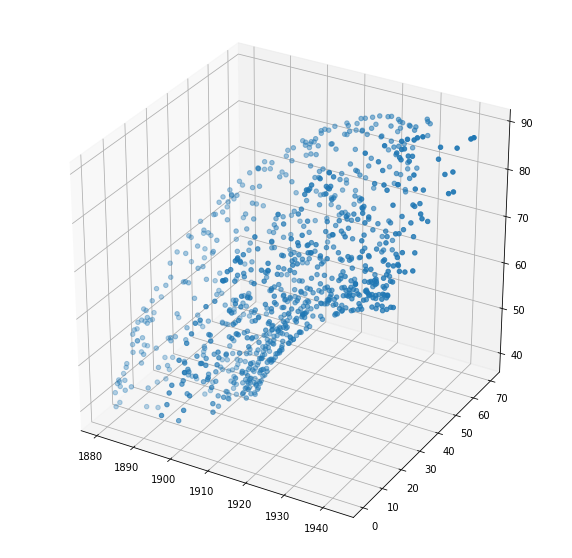

In [ ]:
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(data[normals])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[labels[35], 0], 
           data[labels[35], 1],
           data[labels[35], 3])

plt.show()

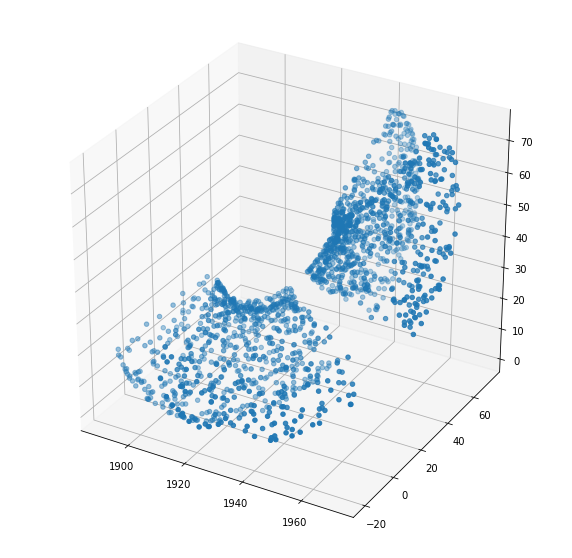

In [ ]:
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(data[normals])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[labels[39], 0], 
           data[labels[39], 1],
           data[labels[39], 3])

plt.show()

In [ ]:
for i in range(m):
  print(len(labels[i]))

1215
3606
2605
1285
735
1364
758
2556
794
1176
844
3324
873
2658
2556
1579
713
2352
2793
773
799
1157
1350
1379
1226
993
1134
969
2967
1231
1685
1889
1122
3053
1086
925
2738
1418
2765
1779
2579
2605
1100
2845
988
2296
2335
1097
1063


In [ ]:
def sphere_fit(point_cloud, lam):
    """
    input
        point_cloud: xyz of the point clouds　numpy array
    output
        radius : radius of the sphere
        sphere_center : xyz of the sphere center
    """

    A_1 = np.zeros((d,d))
    #A_1 : 1st item of A
    v_1 = np.array([0.0] * d)
    v_2 = 0.0
    v_3 = np.array([0.0] * d)
    # mean of multiplier of point vector of the point_clouds
    # v_1, v_3 : vector, v_2 : scalar

    N = len(point_cloud)
    #N : number of the points

    """Calculation of the sum(sigma)"""
    for v in point_cloud:
        v_1 += v
        v_2 += np.dot(v, v)
        v_3 += np.dot(v, v) * v

        A_1 += np.dot(np.array([v]).T, np.array([v]))

    v_1 /= N
    v_2 /= N
    v_3 /= N
    A = 2 * (A_1 / N - np.dot(np.array([v_1]).T, np.array([v_1]))) + np.eye(d, d) * lam / 2
    # formula ②
    b = v_3 - v_2 * v_1 + lam / 2 * v_1
    # formula ③
    # sphere_center = np.dot(np.linalg.inv(A), b)
    sphere_center = np.linalg.lstsq(A, b)[0]
    #　formula ①
    radius = (sum(np.linalg.norm(np.array(point_cloud) - sphere_center, axis=1))
              /len(point_cloud))

    return(radius, sphere_center)

In [ ]:
centers = []
radii = []
for i in range(m):
  radius, center = sphere_fit(data[labels[i]], 2)
  centers.append(center)
  radii.append(radius)
  if i % 5 == 0:
    print(f'{i} steps has done.')


0 steps has done.
5 steps has done.
10 steps has done.
15 steps has done.
20 steps has done.
25 steps has done.
30 steps has done.
35 steps has done.
40 steps has done.
45 steps has done.


In [ ]:
SPHERE_NOISE = 0.05

def is_Sphere(dataset, est_center, est_radius, noise_deviation_percentage):
  distances_from_center = np.linalg.norm(dataset - est_center, axis=1)
  distances_from_radius = np.abs(distances_from_center - est_radius)
  distances_from_radius_per = distances_from_radius / est_radius
  return np.all(distances_from_radius_per < noise_deviation_percentage)

def is_Affine(dataset, exact_error=1):
  pca_affine_detection = PCA(n_components=d)
  pca_affine_embedded = pca_affine_detection.fit_transform(dataset)
  dim = our_find_dimension(dataset)
  a = dataset @ calculate_orth(dataset, dim).T
  left_tail = -exact_error < (a - a.mean(axis=0))
  right_tail = (a - a.mean(axis=0)) < exact_error
  return np.all(left_tail & right_tail)

DIMENSION_DETECTION_TH = 0.001
def our_find_dimension(dataset):
  for i in range(d + 1):
    pca = PCA(n_components=d)
    pca_emb = pca.fit_transform(dataset)
    return len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > DIMENSION_DETECTION_TH])

def calculate_orth(dataset, dim):
  pca = PCA(n_components=d)
  pca_emb = pca.fit_transform(dataset)
  return pca.components_[dim:]

def farahmand_find_dimension(dataset):
  import skdim
  farah = skdim.id.MADA().fit(dataset)
  return round(farah.dimension_)


In [ ]:
def get_sphere_data(data_index, center, radius):
  ans = {}
  ans['Type'] = 'Sphere'
  ans['Data Index'] = data_index
  ans['Dimension'] = our_find_dimension(data[data_index])
  ans['Center'] = center
  ans['Radius'] = radius
  ans['Orth Basis'] = calculate_orth(data[data_index], ans['Dimension'])
  ans['B Vector'] = np.mean(data[data_index], axis=0) @ ans['Orth Basis'].T


  ans['No. Clusters'] = 1
  ans['Clustering'] = np.zeros(len(data_index))

  # clustering_t = SpectralClustering(n_clusters=cnum, n_neighbors = 20, affinity = 'nearest_neighbors', 
  #   assign_labels='kmeans',
  #   random_state=0).fit(data[data_index])

  # ans['No. Clusters'] = cnum
  # ans['Clustering'] =  clustering_t.labels_

  return ans

def get_affine_data(data_index):
  ans = {}
  ans['Type'] = 'Affine'
  ans['Data Index'] = data_index
  ans['Dimension'] = our_find_dimension(data[data_index])
  ans['Orth Basis'] = calculate_orth(data[data_index], ans['Dimension'])
  ans['B Vector'] = np.mean(data[data_index], axis=0) @ ans['Orth Basis'].T

  ans['No. Clusters'] = 1
  ans['Clustering'] = np.zeros(len(data_index))

  # clustering_t = SpectralClustering(n_clusters=cnum, n_neighbors = 20, affinity = 'nearest_neighbors', 
  #   assign_labels='kmeans',
  #   random_state=0).fit(data[data_index])

  # ans['No. Clusters'] = cnum
  # ans['Clustering'] =  clustering_t.labels_
  

  return ans

def get_complex_data(data_index):
  ans = {}
  ans['Type'] = 'Complex'
  ans['Data Index'] = data_index
  ans['Dimension'] = farahmand_find_dimension(data[data_index])

  ans['No. Clusters'] = 1
  ans['Clustering'] = np.zeros(len(data_index))

  # clustering_t = SpectralClustering(n_clusters=cnum, n_neighbors = 20, affinity = 'nearest_neighbors', 
  #   assign_labels='kmeans',
  #   random_state=0).fit(data[data_index])

  # ans['No. Clusters'] = cnum
  # ans['Clustering'] =  clustering_t.labels_

  return ans

In [ ]:
def to_str_c(data):
  ans = ""
  for i in range(len(data)):
    ans += str(data[i]) + " "
  return ans
  
def get_string_data(manifold_data):
  ans = f"{manifold_data['Dimension']} {manifold_data['No. Clusters']} {manifold_data['Type']}\n"
  if manifold_data['Type'] == 'Sphere' or manifold_data['Type'] == 'Affine':
    for jj in range(len(manifold_data['Orth Basis'])):
      ans += f"{to_str_c(manifold_data['Orth Basis'][jj])}\n"
    ans += f"{to_str_c(manifold_data['B Vector'])}\n"

  if manifold_data['Type'] == 'Sphere':
    ans += f"{to_str_c(manifold_data['Center'])} {manifold_data['Radius']}\n"
  
  indices = manifold_data['Data Index'] + 1

  for jj in range(manifold_data['No. Clusters']):
    temp = indices[manifold_data['Clustering'] == jj] 
    ans += f'{len(temp)} {(to_str_c(np.sort(temp)))}\n'

  return ans


In [ ]:
data_for_each_manifold = []
for i in range(m):
  if is_Sphere(data[labels[i]], centers[i], radii[i], SPHERE_NOISE):
    data_for_each_manifold.append(get_sphere_data(labels[i], centers[i], radii[i]))
  # elif is_Affine(data[labels[i]]):
  #   data_for_each_manifold.append(get_affine_data(labels[i]))
  else:
    data_for_each_manifold.append(get_complex_data(labels[i]))
  print(f"{i}th manifold has been handled!")

ans = f'{n} {m}\n'
for data_for_manifold in data_for_each_manifold:
    ans += get_string_data(data_for_manifold)
ans += f'{len(outliers)} {to_str_c(outliers + 1)}'

with open("output.txt", "w") as f:
  f.write(ans)

0th manifold has been handled!
1th manifold has been handled!
2th manifold has been handled!
3th manifold has been handled!
4th manifold has been handled!
5th manifold has been handled!
6th manifold has been handled!
7th manifold has been handled!
8th manifold has been handled!
9th manifold has been handled!
10th manifold has been handled!
11th manifold has been handled!
12th manifold has been handled!
13th manifold has been handled!
14th manifold has been handled!
15th manifold has been handled!
16th manifold has been handled!
17th manifold has been handled!
18th manifold has been handled!
19th manifold has been handled!
20th manifold has been handled!
21th manifold has been handled!
22th manifold has been handled!
23th manifold has been handled!
24th manifold has been handled!
25th manifold has been handled!
26th manifold has been handled!
27th manifold has been handled!
28th manifold has been handled!
29th manifold has been handled!
30th manifold has been handled!
31th manifold has 

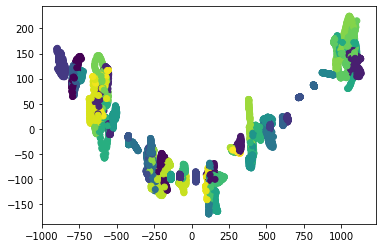

In [ ]:
from sklearn.cluster import KMeans
clustering_minidataset = KMeans(n_clusters=k).fit(clusterable_embedding)
pca = PCA(n_components=3)
pca_embedded = pca.fit_transform(mini_dataset)
plt.scatter(pca_embedded[:,0], pca_embedded[:,1], c = clustering_minidataset.labels_)
plt.show()

In [ ]:
manifold_detection = AgglomerativeClustering(n_clusters=None, distance_threshold=0,linkage='ward', compute_distances=True)
manifold_detection = manifold_detection.fit(clustering_minidataset.cluster_centers_)
drop_off_above_k_1 = []
for i in range(0, k-2):
  drop_off_above_k_1.append(manifold_detection.distances_[i + 1] - manifold_detection.distances_[i])

In [ ]:
manifold_detection = AgglomerativeClustering(n_clusters=None, distance_threshold=0,linkage='single', compute_distances=True)
manifold_detection = manifold_detection.fit(clustering_minidataset.cluster_centers_)
drop_off_above_k_2 = []
for i in range(0, k-2):
  drop_off_above_k_2.append(manifold_detection.distances_[i + 1] - manifold_detection.distances_[i])

In [ ]:
manifold_detection = AgglomerativeClustering(n_clusters=None, distance_threshold=0,linkage='complete', compute_distances=True)
manifold_detection = manifold_detection.fit(clustering_minidataset.cluster_centers_)
drop_off_above_k_3 = []
for i in range(0, k-2):
  drop_off_above_k_3.append(manifold_detection.distances_[i + 1] - manifold_detection.distances_[i])

In [ ]:
manifold_detection = AgglomerativeClustering(n_clusters=None, distance_threshold=0,linkage='average', compute_distances=True)
manifold_detection = manifold_detection.fit(clustering_minidataset.cluster_centers_)
drop_off_above_k_4 = []
for i in range(0, k-2):
  drop_off_above_k_4.append(manifold_detection.distances_[i + 1] - manifold_detection.distances_[i])

In [ ]:
def normalized_arr(arr):
  return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

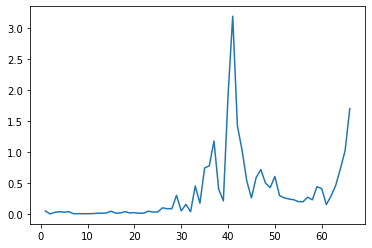

In [ ]:
plt.plot(range(1, k-1), normalized_arr(np.array(drop_off_above_k_1)) + normalized_arr(np.array(drop_off_above_k_2))
                      + normalized_arr(np.array(drop_off_above_k_3)) + normalized_arr(np.array(drop_off_above_k_4)));

In [ ]:
candidates = np.argsort(normalized_arr(np.array(drop_off_above_k_1)) + normalized_arr(np.array(drop_off_above_k_2))
                      + normalized_arr(np.array(drop_off_above_k_3)) + normalized_arr(np.array(drop_off_above_k_4))) [-3:]

In [ ]:
candidates

array([65, 39, 40])

In [ ]:
candidate = 34

In [ ]:
manifolds = AgglomerativeClustering(n_clusters=candidate,linkage='average').fit_predict(clustering_minidataset.cluster_centers_)

In [ ]:
manifolds_together = []
for i in range(candidate):
  manifolds_together.append(np.arange(k)[manifolds == i])

In [ ]:
manifolds_together

[array([17, 31, 39, 48, 49, 66]),
 array([19, 42, 51]),
 array([ 7, 37]),
 array([13, 47]),
 array([ 9, 33, 61]),
 array([ 2, 35, 44, 50, 54]),
 array([25, 63]),
 array([34, 53]),
 array([36]),
 array([ 8, 38, 52, 57]),
 array([21, 45, 60, 64]),
 array([16, 40, 46, 67]),
 array([ 5, 41, 43, 55, 62]),
 array([14]),
 array([30]),
 array([15]),
 array([12, 58]),
 array([0]),
 array([29]),
 array([22, 65]),
 array([32]),
 array([18]),
 array([10, 59]),
 array([23]),
 array([24]),
 array([28]),
 array([ 1, 56]),
 array([11]),
 array([3]),
 array([20]),
 array([27]),
 array([6]),
 array([4]),
 array([26])]

In [ ]:
for i in range(candidate):
  each_group_dimension = []
  for j in range(len(manifolds_together[i])):
    each_group_dimension.append(farahmand_find_dimension(data[labels[manifolds_together[i][j]]]))
  print(each_group_dimension)

[10, 1, 4, 1, 1, 3]
[10, 1, 1]
[2, 1]
[2, 1]
[2, 7, 1]
[2, 3, 7, 1, 1]
[2, 1]
[2, 1]
[2]
[10, 1, 2, 1]
[3, 2, 1, 2]
[2, 2, 1, 1]
[1, 1, 1, 1, 2]
[1]
[6]
[1]
[10, 10]
[10]
[2]
[2, 1]
[10]
[10]
[10, 1]
[2]
[1]
[2]
[1, 1]
[2]
[2]
[2]
[2]
[1]
[2]
[7]
